In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [11]:
df = pd.read_csv('./spam.csv',encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [13]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [14]:
df.columns =['spam','text']


In [15]:
df.head()

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df['spam'] = df['spam'].map({'ham':0,'spam':1})

In [17]:
df['len_text'] = df['text'].apply(lambda x: len(x))

In [18]:
df.head()

,spam,text,len_text
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
ham_mean = df[df['spam'] == 0]['len_text'].mean()
spam_mean = df[df['spam'] == 1]['len_text'].mean()
print('Ham Mean: {}\nSpam Mean:{}'.format(ham_mean,spam_mean))

Ham Mean: 71.02362694300518
Spam Mean:138.8661311914324


### EDA

In [27]:
import random
import numpy as np
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['spam'])

pd.DataFrame({'text':X_test,'spam':y_test}).to_csv('./testing_data')

In [28]:
twt_tokenizer = TweetTokenizer(preserve_case=False)

cv = CountVectorizer(tokenizer= twt_tokenizer.tokenize,max_features=1000)
X_train_text = cv.fit_transform(X_train)


In [29]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_text,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix
X_test_text = cv.transform(X_test)
y_pred = mnb.predict(X_test_text)
accuracy_score(y_test,y_pred)


0.9820531227566404

In [31]:
from helper_functions import plot_confusion_matrix

Confusion matrix, without normalization
[[1216   11]
 [  14  152]]


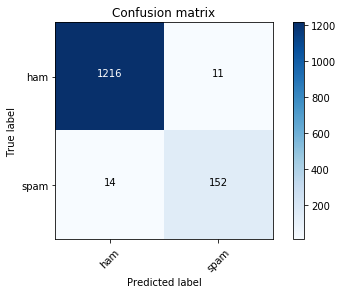

In [32]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,classes=['ham','spam'])

In [33]:
## check out this awesome resource on pipelines!!!! 
## https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines

#### Count Vectorizer

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('count_vect',CountVectorizer(twt_tokenizer.tokenize)),
    ('classifier',MultinomialNB())
])

hyperparameters = { 'count_vect__max_features':[1000,1500,2000],
                  'count_vect__ngram_range': [(1,1),(1,2),(2,2)],
                  'count_vect__stop_words': [None,'english']
}

In [35]:
gs = GridSearchCV(pipeline,hyperparameters,cv=5,verbose=1,n_jobs = -1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x116c8dc18>>,
        lowercase=True, max_df=1.0, ...None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'count_vect__max_features': [1000, 1500, 2000], 'count_vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'count_vect__stop_words': [None, 'english']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [36]:
gs.best_score_

0.9839674563292654

In [37]:
gs.best_params_

{'count_vect__max_features': 1500,
 'count_vect__ngram_range': (1, 1),
 'count_vect__stop_words': None}

In [38]:
mnb_model=gs.best_estimator_

#### TF-IDF vectorizer

In [39]:
pipeline_tf = Pipeline([
    ('tf_idf_vect',TfidfVectorizer(twt_tokenizer.tokenize)),
    ('classifier',MultinomialNB())
])

hyperparameters_tf = { 'tf_idf_vect__max_features':[1000,1500,2000],
                  'tf_idf_vect__ngram_range': [(1,1),(1,2),(2,2)],
                  'tf_idf_vect__stop_words': [None,'english']
}
gs_tf = GridSearchCV(pipeline_tf,hyperparameters_tf,cv=5,verbose=1)
gs_tf.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   14.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tf_idf_vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x116c8dc18>>,
        lowercase=True, max_df=1.0,...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tf_idf_vect__max_features': [1000, 1500, 2000], 'tf_idf_vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'tf_idf_vect__stop_words': [None, 'english']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [40]:
gs_tf.best_params_

{'tf_idf_vect__max_features': 1500,
 'tf_idf_vect__ngram_range': (1, 1),
 'tf_idf_vect__stop_words': 'english'}

In [46]:
## performs worse than a count vectorizer
gs_tf.best_score_

0.9798994974874372

In [42]:
### testing to see if my pipeline works as I expect
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x116c8dc18>>,
        lowercase=True, max_df=1.0, ...None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [43]:
### with many observations
pipeline.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [45]:
### with a single operation
pipeline.predict(['Vodafone special offer if you subscribe now!!'])

array([1])

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
pipeline_lr = Pipeline([
    ('count_vect',CountVectorizer(twt_tokenizer.tokenize)),
    ('classifier',LogisticRegression())
])

hyperparameters_lr = { 'count_vect__max_features':[1000,1500,2000],
                  'count_vect__ngram_range': [(1,1),(1,2),(2,2)],
                  'count_vect__stop_words': [None,'english'],
                   'classifier__C': [0.001,0.1,1,1000],
                   'classifier__penalty' : ['l1','l2']
                    }

In [48]:
gs_lr = GridSearchCV(pipeline_lr,hyperparameters_lr,cv=5,verbose=1,n_jobs = -1)
gs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   55.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x116c8dc18>>,
        lowercase=True, max_df=1.0, ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'count_vect__max_features': [1000, 1500, 2000], 'count_vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'count_vect__stop_words': [None, 'english'], 'classifier__C': [0.001, 0.1, 1, 1000], 'classifier__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [49]:
print(gs_lr.best_score_)
print(gs_lr.best_params_)
lr_model = gs_lr.best_estimator_

0.9813352476669059
{'classifier__C': 1, 'classifier__penalty': 'l2', 'count_vect__max_features': 2000, 'count_vect__ngram_range': (1, 1), 'count_vect__stop_words': None}


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('count_vect',CountVectorizer(twt_tokenizer.tokenize)),
    ('classifier',RandomForestClassifier())
])

hyperparameters_rf = { 'count_vect__max_features':[1000,1500,2000],
                  'count_vect__ngram_range': [(1,1),(1,2),(2,2)],
                  'count_vect__stop_words': [None,'english'],
                   'classifier__max_depth':[1,3,None],
                   'classifier__n_estimators':[10,100,200,300],
                    'classifier__min_samples_leaf':[1,20,50],
                      'classifier__n_jobs':[-1]
                    }

In [51]:
### this will take a while!!
gs_rf = GridSearchCV(pipeline_rf,hyperparameters_rf,cv=5,verbose=1,n_jobs =-1)
gs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 17.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8',
        input=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x116c8dc18>>,
        lowercase=True, max_df=1.0, ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'count_vect__max_features': [1000, 1500, 2000], 'count_vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'count_vect__stop_words': [None, 'english'], 'classifier__max_depth': [1, 3, None], 'classifier__n_estimators': [10, 100, 200, 300], 'classifier__min_samples_leaf': [1, 20, 50], 'classifier__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [52]:
rf_model =gs_rf.best_estimator_

### Assuming we've decided on a best model, you can then "pickle" your trained model. This persists your trained model and enables you to use it in a web application without retraining the model each time. Typically, you'll only be pickling one model that you've deemed best, but for this example I'm going to save my top Naive Bayes, Logisitic Regression, and Random Forest models. 

Read more about them here: http://scikit-learn.org/stable/modules/model_persistence.html


In [54]:
import pickle
with open('mnb.pkl',mode='wb') as file:
    pickle.dump(mnb_model,file)
with open('lr.pkl',mode='wb') as file:
    pickle.dump(lr_model,file)
with open('rf.pkl','wb') as file:
    pickle.dump(rf_model,file)

In [56]:
import numpy as np
mnb_coef = mnb_model.named_steps.classifier.coef_
ordered_coef = np.argsort(mnb_coef[0])

### More analysis for feature importance

In [57]:
ordered_coef

array([ 749,  780,  781, ..., 1490,  221, 1300])

In [59]:
features = np.array(mnb_model.named_steps.count_vect.get_feature_names())

In [60]:
features[ordered_coef][:100]

array(['lol', 'makes', 'making', 'malaria', 'march', 'mark', 'marriage',
       'marry', 'mate', 'matter', 'mayb', 'mean', 'meaning', 'means',
       'meant', 'medical', 'meeting', 'meh', 'merry', 'might', 'mine',
       'miracle', 'mm', 'mo', 'mode', 'model', 'mail', 'maid', 'mah',
       'ma', 'lect', 'leh', 'lei', 'less', 'lesson', 'lessons', 'lets',
       'liao', 'library', 'lift', 'light', 'liked', 'mom', 'lmao', 'long',
       'longer', 'looked', 'lor', 'lot', 'lovable', 'loved', 'lovely',
       'loves', 'loving', 'lt', 'lunch', 'û_', 'moment', 'mon', 'monday',
       'omg', 'omw', 'once', 'online', 'oops', 'orchard', 'oredi', 'oso',
       'others', 'otherwise', 'outside', 'own', 'okie', 'pa', 'paper',
       'parents', 'party', 'past', 'persons', 'pete', 'picking',
       'pictures', 'pilates', 'pissed', 'pizza', 'plan', 'pain',
       'leaving', 'okay', 'nope', 'moral', 'morning', 'mother', 'move',
       'movies', 'mrng', 'mrt', 'mu', 'mum', 'murdered'], dtype='<U15')

In [62]:
features[ordered_coef][-100:]

array(['want', 'ringtone', 'can', 'me', 'message', 'box', '10', 'go',
       'has', 'more', 'at', 'code', 'shows', 'if', 'video', 'every',
       'apply', 'mins', 'it', 'latest', 'find', 'number', '150ppm', 'by',
       'line', 'landline', 'camera', 'as', 'been', '1000', 'sms', 'draw',
       '100', 'min', 'awarded', 'per', '500', 'will', 'cs', 'phone', 'be',
       'chat', 'guaranteed', 'we', 'customer', 'service', 'co', '18',
       'contact', 'please', 'who', '16', 'tone', 'com', 'week', 'msg',
       'win', '50', 'urgent', 'no', 'out', 'new', 'nokia', 'are', 'won',
       'send', 'in', '150p', 'uk', 'cash', 'just', 'only', 'prize', 'get',
       'this', 'our', 'of', 'www', 'reply', 'claim', 'with', 'and',
       'have', 'text', 'stop', 'mobile', 'from', 'on', 'ur', 'is', 'txt',
       'or', 'now', 'the', 'for', 'free', 'you', 'your', 'call', 'to'],
      dtype='<U15')

In [63]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

## ROC Curve

In [64]:
y_probs_mnb = mnb_model.predict_proba(X_test)
y_probs_lr =  lr_model.predict_proba(X_test)
y_probs_rf = rf_model.predict_proba(X_test)
preds_mnb = y_probs_mnb[:,1]
preds_lr = y_probs_lr[:,1]
preds_rf = y_probs_rf[:,1]

In [65]:
fpr_mnb, tpr_mnb, threshold_mnb = roc_curve(y_test, preds_mnb)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, preds_lr)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, preds_rf)
roc_auc_mnb = auc(fpr_mnb,tpr_mnb)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf,tpr_rf)

In [66]:
lw = 2

trace1 = go.Scatter(x=fpr_mnb, y=tpr_mnb, 
                    mode='lines', 
                    line=dict(color='red', width=lw),
                    name='ROC curve MNB (area = %0.5f)' % roc_auc_mnb
                   )

trace2 = go.Scatter(x=fpr_lr, y=tpr_lr, 
                    mode='lines', 
                    line=dict(color='green', width=lw),
                    name='ROC curve Log Reg (area = %0.5f)' % roc_auc_lr
                   )
trace3 = go.Scatter(x=fpr_rf, y=tpr_rf, 
                    mode='lines', 
                    line=dict(color='darkorange', width=lw),
                    name='ROC curve Random Forest (area = %0.5f)' % roc_auc_rf
                   )

trace4 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=lw, dash='dash'),
                    showlegend=False)

layout = go.Layout(title='Receiver operating characteristic example',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=[trace1, trace2,trace3,trace4], layout=layout)

In [67]:
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *

init_notebook_mode(connected=True) 
iplot(fig)

In [69]:
from sklearn.metrics import confusion_matrix

def make_confusion_matrix_plotly(y_pred,y_test,model_name,normalize = False):
    cm = confusion_matrix(y_test,y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    trace = go.Heatmap(z= cm,
                   x=['Not Spam','Spam'],    
                   y=['Not Spam','Spam']
                   )
    
    layout = go.Layout(title='Confusion Matrix: {}'.format(model_name),
                   xaxis=dict(title='Predicted Values'),
                   yaxis=dict(title='Actual Values'),
                   margin = {'l': 80}
                       
                      )
    
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

In [71]:
y_preds_mnb = mnb_model.predict(X_test)
y_preds_lr =  lr_model.predict(X_test)
y_preds_rf = rf_model.predict(X_test)


In [72]:
make_confusion_matrix_plotly(y_preds_mnb,y_test,'Multinomial Naive Bayes',normalize=True)

In [73]:
make_confusion_matrix_plotly(y_preds_lr,y_test,'Logistic Regression',normalize=True)

In [74]:
make_confusion_matrix_plotly(y_preds_rf,y_test,'Random Forest',normalize=True)